In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import io, datasets, transforms
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# constants
img_width = 384
img_height = 128
batch_size = 50
op_str = '0123456789+-*/'

In [6]:
outfile = open('annotations_digits.csv', 'w', newline='')

output = csv.writer(outfile)
output.writerow(['Image','Label','Left','Operator','Right','Value'])

ctr = 0
num = 0
while ctr < 50000:
    i = (num//10)%10
    j = num%10
    for k in ['+', '-', '*', '/']:
        for l in ['prefix', 'postfix', 'infix']:
            if ctr >= 50000:
                break
            if k == '/' and (j == 0 or (i/j)%1 != 0):
                continue
            ctr += 1
            if l == 'prefix':
                output.writerow([f'{ctr}.jpg', l, k, i, j, int(eval(f'{i}{k}{j}'))])
            elif l == 'infix':
                output.writerow([f'{ctr}.jpg', l, i, k, j, int(eval(f'{i}{k}{j}'))])
            else:
                output.writerow([f'{ctr}.jpg', l, i, j, k, int(eval(f'{i}{k}{j}'))])                
        if ctr >= 50000:
            break
    num += 1

print(ctr)

50000


In [7]:
#enable cuda
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device('cuda')
    loader_kwargs = {'num_workers': 1, 'pin_memory': True}
else:
    device = torch.device('cpu')
    loader_kwargs = {}
    
print(device)

cuda


50000


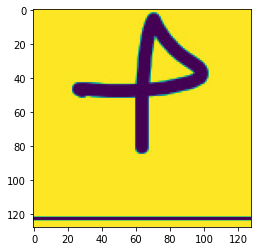

In [8]:
class ExpressionDataset(Dataset):
    """Binomial expression dataset"""
    
    def __init__(self, csv_file, root_dir):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transforms.ToTensor()
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, self.labels.iloc[idx,0])
        img = Image.open(img_name)
        leftimg = img.crop((0,0,img_height,img_height))
        middleimg = img.crop((img_height,0,img_height*2,img_height))
        rightimg = img.crop((img_height*2,0,img_height*3,img_height))
        exprtype, left, op, right, ans = self.labels.iloc[idx,1:]
        exprtype_int = 0
        if exprtype == "infix":
            exprtype_int = 1
        elif exprtype == "postfix":
            exprtype_int = 2
        return [self.transform(img).float(), self.transform(leftimg).float(), self.transform(middleimg).float(), self.transform(rightimg).float(), exprtype_int, op_str.index(left), op_str.index(op), op_str.index(right), ans]

dataset = ExpressionDataset(csv_file='/kaggle/working/annotations_digits.csv', root_dir='../input/soml-hackathon/SoML/SoML-50-old/data')
plt.imshow(dataset[10][3].squeeze())
print(len(dataset))

train_set, test_set, validation_set = torch.utils.data.random_split(dataset, [40000,5000,5000])

train_loader = DataLoader(train_set, batch_size=50, shuffle=True)
test_loader = DataLoader(test_set, batch_size=50, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=50, shuffle=True)

In [9]:
class DigitNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(2420, 100)
        self.fc2 = nn.Linear(100, 14)       
#        self.input_layer = torch.nn.Linear(784, 112)
#        self.hl2 = torch.nn.Linear(112, 14)
#        self.relu = torch.nn.ReLU()

    def forward(self, x):        
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 3))
        x = torch.flatten(x,1)
#        print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return x
#        x = self.input_layer(x)
#        x = self.relu(x)
#        x = self.hl2(x)
    
    def digit_acc(self, loader):
        total = 0
        correct = 0
        
        with torch.no_grad(): 
            for fullimg, leftimg, midimg, rightimg, types, left, mid, right, ans in loader:
                batch_size = fullimg.shape[0]
                sections = [[leftimg,left], [midimg,mid], [rightimg,right]]
                for images, labels in sections:
                    images, labels = images.to(device), labels.to(device)
                    batch_size = images.shape[0]
                    #images = images.reshape(batch_size, 28*28)
                    output = digit_net(images)

                    prediction = torch.argmax(output, dim=1)
                    correct += torch.sum(prediction == labels)
                    total += batch_size
        
        return correct/total
    
    def acc(self, loader):
        total = 0
        correct = 0
        op_str = "0123456789+-*/"
        
        with torch.no_grad(): 
            for fullimg, leftimg, midimg, rightimg, types, left, mid, right, ans in loader:
                ans = ans.to(device)
                sections = [leftimg, midimg, rightimg]
                batch_size = fullimg.shape[0]
                predictions = []
                answers = []
                for images in sections:
                    images = images.to(device)
                    output = self(images)

                    predicted = torch.argmax(output, dim=1)
                    predictions.append(predicted)
                for i in range(batch_size):
                    l,m,r = predictions[0][i], predictions[1][i], predictions[2][i]
                    if l >= 10: # prefix
                        answers.append(eval(f'{m}{op_str[l]}{r}'))
                    elif m >= 10: # infix
                        answers.append(eval(f'{l}{op_str[m]}{r}'))
                    elif r >= 10: # postfix
                        answers.append(eval(f'{l}{op_str[r]}{m}'))
                    else:
                        answers.append(0)
                
                correct += torch.sum(torch.tensor(answers).to(device) == ans)
                total += batch_size
        
        return correct/total

In [10]:
digit_net = DigitNetwork().to(device)
lossfn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(digit_net.parameters(), lr=0.001)

print(f"Accuracy: {digit_net.digit_acc(validation_loader)}")
for epoch in range(8):
    avg_loss = 0
    num_iters = 0
    digit_net.train()
    for fullimgs, leftimgs, midimgs, rightimgs, types, left, mid, right, answers in tqdm(train_loader):
        sections = [[leftimgs,left], [midimgs,mid], [rightimgs,right]]
        for images, labels in sections:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            batch_size = images.shape[0]
            #images = images.reshape(batch_size, 28*28)
            output = digit_net(images)
            loss = lossfn(output, labels)

            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            num_iters += 1
    digit_net.eval()    
    print(f"Loss: {avg_loss/num_iters}")
    print(f"Accuracy: {digit_net.digit_acc(validation_loader)}")

Accuracy: 0.06566666811704636


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.7577948328542212
Accuracy: 0.9768000245094299


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.3727912529123326
Accuracy: 0.9943333268165588


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.2836796678773438
Accuracy: 0.9983333349227905


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.23863411257043482
Accuracy: 0.9993333220481873


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.21171188598886753
Accuracy: 0.9998000264167786


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.18825708677759395
Accuracy: 0.9998000264167786


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.1734037021151744
Accuracy: 0.9997333288192749


  0%|          | 0/800 [00:00<?, ?it/s]

Loss: 0.16460524486028588
Accuracy: 0.9997333288192749


In [11]:
digit_net.eval()
print(f"Accuracy on expressions: {digit_net.acc(test_loader)}")

Accuracy on expressions: 0.9993999600410461


In [12]:
torch.save(digit_net.state_dict(), '/kaggle/working/value_net_dict')